In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2 -O /content/drive/MyDrive/flavia_leaves/dataset/Leaves.tar.bz2

--2021-01-25 09:42:38--  https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2
Resolving sourceforge.net (sourceforge.net)... 216.105.38.13
Connecting to sourceforge.net (sourceforge.net)|216.105.38.13|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/ [following]
--2021-01-25 09:42:39--  https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/download [following]
--2021-01-25 09:42:39--  https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 302 Found
Location: htt

In [ ]:
import tarfile

Extract the downloaded archive.

In [ ]:
tar_file = tarfile.open('drive/MyDrive/flavia_leaves/dataset/Leaves.tar.bz2', 'r:bz2')
tar_file.extractall('drive/MyDrive/flavia_leaves/dataset/')
tar_file.close()

In [ ]:
import os

Check the number of images in the dataset.

In [ ]:
len(os.listdir('drive/MyDrive/flavia_leaves/dataset/Leaves'))

1907

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from bs4 import BeautifulSoup
import requests

The flavia dataset contains all leaves in a single folder with names as numbers. We have to extract the labels from the website which specifies which file is of which class.

In [ ]:
result = requests.get('http://flavia.sourceforge.net/')
soup = BeautifulSoup(result.content, 'lxml')

The website has a table containing scientific names, common names, filenames. It would be helful if we can somehow replicate that table in a pandas dataframe of our own. 

In [ ]:
df = pd.DataFrame(columns=['label', 'scientific_name', 'common_name', 'filename', 'url'])
entry=[]
table = soup.find_all('td')
for row in table:
  entry.append(row.text)
  if len(entry)==5:
    df.loc[len(df.index)]=entry
    entry.clear()

In [ ]:
df.shape

(32, 5)

In [ ]:
df.head(3)

,label,scientific_name,common_name,filename,url
0,1,Phyllostachys edulis (Carr.) Houz.,pubescent bamboo,1001-1059,http://www.itis.gov/servlet/SingleRpt/SingleRp...
1,2,Aesculus chinensis,Chinese horse chestnut,1060-1122,http://www.ars-grin.gov/cgi-bin/npgs/html/taxo...
2,3,Berberis anhweiensis Ahrendt,Anhui Barberry,1552-1616,http://asaweb.huh.harvard.edu:8080/databases/s...


It might come in handy later if we split the filename column to two columns which contain the start filename and end filename.

In [ ]:
start_filename=pd.Series()
end_filename=pd.Series()
for start, end in df.filename.str.split('-', 1):
  start_filename.loc[len(start_filename.index)] = start
  end_filename.loc[len(end_filename.index)] = end
# b.append(df.filename.str.split('-'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
df['start_filename'] = start_filename
df['end_filename'] = end_filename

In [ ]:
df['start_filename'] = df['start_filename'].astype(int)
df['end_filename'] = df['end_filename'].astype(int)

In [ ]:
df.drop('filename', axis=1, inplace=True)
df.head(3)

,label,scientific_name,common_name,url,start_filename,end_filename
0,1,Phyllostachys edulis (Carr.) Houz.,pubescent bamboo,http://www.itis.gov/servlet/SingleRpt/SingleRp...,1001,1059
1,2,Aesculus chinensis,Chinese horse chestnut,http://www.ars-grin.gov/cgi-bin/npgs/html/taxo...,1060,1122
2,3,Berberis anhweiensis Ahrendt,Anhui Barberry,http://asaweb.huh.harvard.edu:8080/databases/s...,1552,1616


We might use the common name column for different purposes so lets make sure it doesnot contain any spaces and commas.

In [ ]:
df['common_name'] = df.common_name.str.replace(' ', '_').str.replace(',', '')
df.head(3)

,label,scientific_name,common_name,url,start_filename,end_filename
0,1,Phyllostachys edulis (Carr.) Houz.,pubescent_bamboo,http://www.itis.gov/servlet/SingleRpt/SingleRp...,1001,1059
1,2,Aesculus chinensis,Chinese_horse_chestnut,http://www.ars-grin.gov/cgi-bin/npgs/html/taxo...,1060,1122
2,3,Berberis anhweiensis Ahrendt,Anhui_Barberry,http://asaweb.huh.harvard.edu:8080/databases/s...,1552,1616


In [ ]:
import pathlib
import shutil

Create the train and test directories and folders for all respective classes inside both.

In [ ]:
for cname in df.common_name:
  pathlib.Path('drive/MyDrive/flavia_leaves/dataset/train/'+cname).mkdir(parents=True, exist_ok=True)
  pathlib.Path('drive/MyDrive/flavia_leaves/dataset/valid/'+cname).mkdir(parents=True, exist_ok=True)

In [ ]:
all_images = os.listdir('drive/MyDrive/flavia_leaves/dataset/Leaves/')
len(all_images)

1907

In [ ]:
train_dir = 'drive/MyDrive/flavia_leaves/dataset/train'
valid_dir = 'drive/MyDrive/flavia_leaves/dataset/valid'

source_dir = 'drive/MyDrive/flavia_leaves/dataset/Leaves'

In [ ]:
np.random.seed(42)
def split_train_valid(start_fname, end_fname, train_split, common_name):
  
  pool=list(range(start_fname, end_fname+1))
  np.random.shuffle(pool)
  for i, file_number in enumerate(pool):
    file_number = str(file_number)
    if i < int(np.ceil(train_split*len(pool))):
      shutil.copyfile(source_dir+'/'+file_number+'.jpg', train_dir+'/'+common_name+'/'+file_number+'.jpg')
    else:
      shutil.copyfile(source_dir+'/'+file_number+'.jpg', valid_dir+'/'+common_name+'/'+file_number+'.jpg')


In [ ]:
i=0
while i<len(df.index):
  split_train_valid(df.loc[i].start_filename, df.loc[i].end_filename, train_split=0.8,
                    common_name=df.loc[i].common_name)
  i+=1

In [ ]:
df.dtypes

label              object
scientific_name    object
common_name        object
url                object
start_filename      int64
end_filename        int64
dtype: object

In [ ]:
def check_parity():
  numbers=0
  for class_ in os.listdir(train_dir):
    numbers+= len(os.listdir(train_dir+'/'+class_))
  for class_ in os.listdir(valid_dir):
    numbers+= len(os.listdir(valid_dir+'/'+class_))
  if numbers==len(os.listdir(source_dir)):
    print(numbers)
    print(len(os.listdir(source_dir)))
    print('Train valid split went perfectly')
  else:
    print('Train valid split was not perfect')

check_parity()

1907
1907
Train valid split went perfectly


In [ ]:
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

The `remove_background` function is for removing backgrounds for user given images. As the flavia dataset contains leaf images with white background, It will be easier for the model if the user inputs are in white background as well.

In [ ]:
def remove_background(img_path):
  test_img_path = img_path
  
  #Reading the image
  main_img = cv2.imread(test_img_path)
  img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
  #plt.imshow(img,cmap="Greys_r")

  #Resizing the image to 1600,1200
  resized_image = cv2.resize(img, (1600, 1200))
  #plt.imshow(resized_image,cmap="Greys_r")

  y,x,_ = img.shape

  #Converting image into grayscale
  gs = cv2.cvtColor(resized_image,cv2.COLOR_RGB2GRAY)
  #plt.imshow(gs,cmap="Greys_r")

  #Smoothing image using Guassian filter of size (55,55).
  blur = cv2.GaussianBlur(gs, (55,55),0)
  #plt.imshow(blur,cmap="Greys_r")

  #Adaptive image thresholding using Otsu's thresholding method¶
  ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  #plt.imshow(im_bw_otsu,cmap='Greys_r')

  #Closing of holes using Morphological Transformation¶
  #Performed so as to close any holes present in the leaf
  kernel = np.ones((50,50),np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
  #plt.imshow(closing,cmap="Greys_r")

  #Finding contours
  contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  #Finding the correct leaf contour from the list of contours
  #The following function finds the correct leaf contour by taking any coordinate point of the leaf
  #(default - center point) and checks whether the current contour contains that point or not.
  #Returns the index of the correct contour.
  def find_contour(cnts):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    return val[0]

  #Creating mask image for background subtraction using leaf contour
  black_img = np.empty([1200,1600,3],dtype=np.uint8)
  black_img.fill(0)
  #plt.imshow(black_img,cmap="Greys_r")

  index = find_contour(contours)
  cnt = contours[index]
  mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
  #plt.imshow(mask)

  #Performing masking operation on the original image¶
  maskedImg = cv2.bitwise_and(resized_image, mask)
  white_pix = [255,255,255]
  black_pix = [0,0,0]

  final_img = maskedImg
  h,w,channels = final_img.shape
  for x in range(0,w):
    for y in range(0,h):
      channels_xy = final_img[y,x]
      if all(channels_xy == black_pix):    
        final_img[y,x] = white_pix

  #Background subtracted image
  return final_img

In [ ]:
image = remove_background('drive/MyDrive/leaf/leaves.jpg')

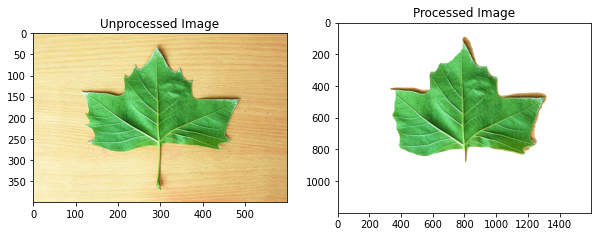

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(mpimg.imread('drive/MyDrive/leaf/leaves.jpg'))
ax1.set(title='Unprocessed Image')
ax2.imshow(image)
ax2.set(title='Processed Image');

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=40,
                                   height_shift_range=0.2, width_shift_range=0.2,
                                   shear_range=0.2, fill_mode='nearest')

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1.0/255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224),
                                                    class_mode='categorical', batch_size=32)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224,224),
                                                    class_mode='categorical', batch_size=32)

Found 1536 images belonging to 32 classes.
Found 371 images belonging to 32 classes.


In [ ]:
indices = train_generator.class_indices
indices ={values : keys for keys,values in indices.items()}
indices

{0: 'Anhui_Barberry',
 1: "Beale's_barberry",
 2: 'Big-fruited_Holly',
 3: 'Canadian_poplar',
 4: 'Chinese_Toon',
 5: 'Chinese_cinnamon',
 6: 'Chinese_horse_chestnut',
 7: 'Chinese_redbud',
 8: 'Chinese_tulip_tree',
 9: 'Crape_myrtle_Crepe_myrtle',
 10: 'Ford_Woodlotus',
 11: 'Glossy_Privet',
 12: 'Japan_Arrowwood',
 13: 'Japanese_Flowering_Cherry',
 14: 'Japanese_cheesewood',
 15: 'Japanese_maple',
 16: 'Nanmu',
 17: 'camphortree',
 18: 'castor_aralia',
 19: 'deodar',
 20: 'ginkgo_maidenhair_tree',
 21: 'goldenrain_tree',
 22: 'oleander',
 23: 'peach',
 24: 'pubescent_bamboo',
 25: 'southern_magnolia',
 26: 'sweet_osmanthus',
 27: 'tangerine',
 28: 'trident_maple',
 29: 'true_indigo',
 30: 'wintersweet',
 31: 'yew_plum_pine'}

In [ ]:
from keras.optimizers import Adam

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
x = mobile.layers[-6].output

In [ ]:
output = keras.layers.Dense(units=32, activation='softmax')(x)

In [ ]:
mobile_model = keras.Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in mobile_model.layers[:-23]:
    layer.trainable = False

In [ ]:
mobile_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mobile_history = mobile_model.fit_generator(train_generator, steps_per_epoch=46, epochs=20, verbose=2, validation_data=valid_generator,
                              validation_steps=12)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
46/46 - 1136s - loss: 1.5541 - accuracy: 0.6393 - val_loss: 2.3792 - val_accuracy: 0.3100
Epoch 2/20
46/46 - 92s - loss: 0.2482 - accuracy: 0.9742 - val_loss: 1.1735 - val_accuracy: 0.6388
Epoch 3/20
46/46 - 74s - loss: 0.1208 - accuracy: 0.9912 - val_loss: 0.5060 - val_accuracy: 0.8787
Epoch 4/20
46/46 - 74s - loss: 0.0803 - accuracy: 0.9932 - val_loss: 0.2133 - val_accuracy: 0.9596
Epoch 5/20
46/46 - 74s - loss: 0.0550 - accuracy: 0.9986 - val_loss: 0.0917 - val_accuracy: 0.9865
Epoch 6/20
46/46 - 74s - loss: 0.0455 - accuracy: 0.9939 - val_loss: 0.0665 - val_accuracy: 0.9892
Epoch 7/20
46/46 - 74s - loss: 0.0336 - accuracy: 0.9986 - val_loss: 0.0431 - val_accuracy: 0.9919
Epoch 8/20
46/46 - 74s - loss: 0.0222 - accuracy: 0.9993 - val_loss: 0.0301 - val_accuracy: 0.9973
Epoch 9/20
46/46 - 73s - loss: 0.0220 - accuracy: 0.9986 - val_loss: 0.0250 - val_accuracy: 0.9946
Epoch 10/20
46/46 - 73s - loss: 0.0213 - accuracy: 0.9980 - val_loss: 0.0191 - val_accuracy: 0.9973
Epoch 1

In [ ]:
mobile_model.save('drive/MyDrive/flavia_leaves/models/mobilenet_model.h5')

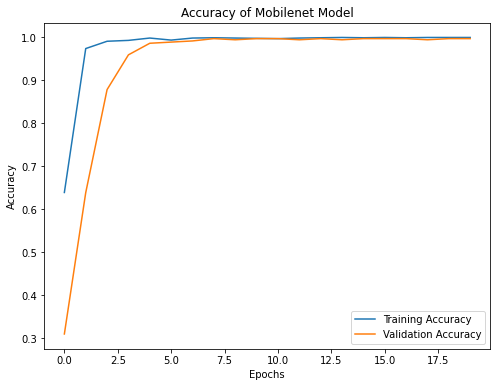

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(mobile_history.history['accuracy'], label='Training Accuracy')
ax.plot(mobile_history.history['val_accuracy'], label='Validation Accuracy')
ax.set(xlabel='Epochs', ylabel='Accuracy', title='Accuracy of Mobilenet Model')
ax.legend();

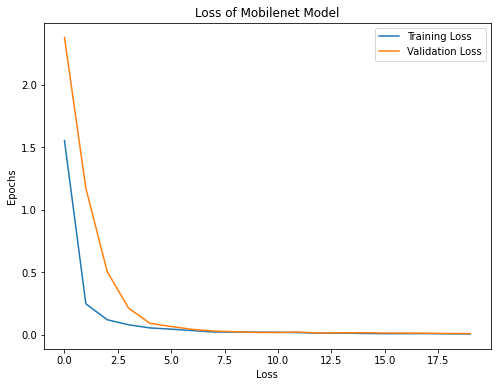

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(mobile_history.history['loss'], label='Training Loss')
ax.plot(mobile_history.history['val_loss'], label='Validation Loss')
ax.set(xlabel='Loss', ylabel='Epochs', title='Loss of Mobilenet Model')
ax.legend();